<a href="https://colab.research.google.com/github/trentfridey/qosf-screening/blob/master/Task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1

## Summary

In this notebook, we explore the ability of a QAOA-style circuit in preparing a given four-qubit quantum state. The circuit is made of layers of alternating operators, which contain variational parameters that we optimize to prepare the given state. The circuit's ability to prepare a given quantum state is quantified by a cost function, which is calculated for a number of layers.

## Technical description

The cost function we are trying to minimize at the end of the circuit is:

$$
\varepsilon = \min_{\theta}|||\psi(\theta)\rangle - |\phi\rangle|| 
$$

where $|\psi(\theta)\rangle$ is the output state of the circuit, and we choose (without loss of generality) 

$$
|\phi\rangle = \frac{1}{\sqrt{2}}(|1111\rangle + |0000\rangle)
$$

This state is interesting because it represents the entangled [GHZ](https://en.wikipedia.org/wiki/Greenberger%E2%80%93Horne%E2%80%93Zeilinger_state) state.

The initial state of the qubits is $|\psi\rangle = |0000\rangle$.

## Circuit Analysis

The circuit is composed of layers, which can be broken down into even and odd blocks. The operator for $i^{th}$ block is

$$
U_{i}^{\text{odd}}(\mathbf{\theta}_i) = \bigotimes_{n=1}^4 R_x(\theta_{i,n})
$$

$$
U_{i}^{\text{even}}(\mathbf{\theta}_i) = \left(\prod_{\langle j,k \rangle}CZ(j,k)\right)\bigotimes_{n=1}^4 R_z(\theta_{i,n})
$$

Where $\langle j,k \rangle$ denotes the ordered pairs of qubits.

The operator for the $\ell^{th}$ layer is:

$$
U_\ell = U_{2\ell}^{\text{even}} U_\ell^{\text{odd}}
$$

Repeated application of this unitary operator results in applying the circuit multiple times.

## Implementation

In the Python code below, we calculate $\varepsilon$ by first constructing the unitary operator for the circuit with a specified number of layers (`n_layers`), then multiplying it with $|0000\rangle$ to get $\left|\psi(\theta)\right\rangle$. For the minimization, we use the `autograd` library and employ `adam`.

In [86]:
import autograd.numpy as np
from autograd import grad
from functools import reduce
from autograd.misc.optimizers import adam
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [127]:
def epsilon(n_layers, debug=False):

  print("Number of Layers: {}".format(n_layers))
  # Operators

  sx = np.array([[0,1],[1,0]])
  sy = np.array([[0,-1j],[1j,0]])
  sz = np.array([[1,0],[0,-1]])

  p0 = np.array([[1,0],[0,0]])
  p1 = np.array([[0,0],[0,1]])

  # Gates

  def Rx(theta):
    return np.array([[np.cos(0.5*theta), -1j*np.sin(0.5*theta)],
                     [-1j*np.sin(0.5*theta), np.cos(0.5*theta)]])

  def Ry(theta):
    return np.array([[np.cos(0.5*theta), -1*np.sin(0.5*theta)],
                     [np.sin(0.5*theta), np.cos(0.5*theta)]])

  def Rz(theta):
    return np.array([[np.cos(-0.5*theta) + 1j*np.sin(-0.5*theta), 0], 
                     [0, np.cos(0.5*theta) + 1j*np.sin(0.5*theta)]])

  def CZ(i,j):
    ops0 = [np.eye(2) for i in range(4)]
    ops1 = [np.eye(2) for i in range(4)]
    ops0[i] = p0
    ops1[i] = p1
    ops1[j] = sz
    cz0 = reduce(lambda res, op: np.kron(res, op), ops0)
    cz1 = reduce(lambda res, op: np.kron(res, op), ops1)
    return cz0 + cz1

  # Blocks

  def odd(thetas):
    rot = Rx(thetas[0])
    rots = [Rx(theta) for theta in thetas[1:]]
    for r in rots:
      rot = np.kron(rot,r)
    return rot

  def even(thetas):
    rot = Rx(thetas[0])
    rots = [Rz(theta) for theta in thetas[1:]]
    for r in rots:
      rot = np.kron(rot, r)
    CZs = np.eye(16)
    for i in range(3):
      for j in range(i+1, 4):
        CZs = CZ(i,j) @ CZs
    return CZs @ rot

  # Layer

  def layer(thetas):
    return even(thetas[4:8]) @ odd(thetas[0:4]) 

  # Circuit

  def circuit(thetas):
    circuit = np.eye(16)
    for l in range(n_layers):
      circuit = layer(thetas[8*l:8*(l+1)]) @ circuit
    return circuit

  # Objective

  start_state = np.array([1] + [0 for i in range(1,16)])
  target = 0.5*np.sqrt(2) *(np.array([1] + [0 for i in range(1,15)] + [1]))

  def objective(thetas,iter):
    circ = circuit(thetas)
    return np.sum(np.abs(np.dot(circ, start_state)/np.sum(np.abs(np.dot(circ, start_state))) - target))

  # Optimization

  grad_obj = grad(objective)

  init_thetas = np.random.normal(0, np.pi, 8*n_layers)
  step_size = 0.1
  num_iters = 400 + 20*n_layers

  def handle_step(params, iter, grad):
    if iter % 20 == 0 and debug:
      print("Cost after {} steps is {}".format(iter, objective(params, iter)))

  optimized_thetas = adam(grad_obj, init_thetas, step_size=step_size, num_iters=num_iters, callback=handle_step)

  epsilon = objective(optimized_thetas,0)
  if debug:
    opt_circuit = circuit(optimized_thetas)
    final_state = np.dot(opt_circuit, start_state) 
    return optimized_thetas, opt_circuit, final_state, epsilon
  return epsilon

In [131]:
# Generate data for plot
n_layers = 5

def gen_data_points():
  return [epsilon(n) for n in range(1,n_layers)]

# We use 5 runs to average out initialization effects
runs = 5
e_data = [gen_data_points() for i in range(runs)]

Number of Layers: 1
Number of Layers: 2
Number of Layers: 3
Number of Layers: 4
Number of Layers: 1
Number of Layers: 2
Number of Layers: 3
Number of Layers: 4
Number of Layers: 1
Number of Layers: 2
Number of Layers: 3
Number of Layers: 4
Number of Layers: 1
Number of Layers: 2
Number of Layers: 3
Number of Layers: 4
Number of Layers: 1
Number of Layers: 2
Number of Layers: 3
Number of Layers: 4


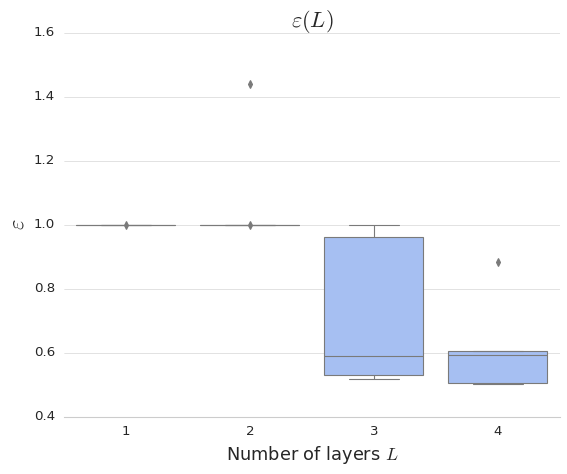

In [132]:
df = pd.DataFrame(e_data, columns=[i for i in range(1,n_layers)])
sns.set_style(style="whitegrid")
sns.set_palette("deep")
ax = sns.boxplot(data=df, color="#99bbff")
ax.set_title(r'$\varepsilon(L)$', fontsize=20)
ax.set_xlabel(r'Number of layers $L$', fontsize=16)
ax.set_ylabel(r'$\varepsilon$', fontsize=20);
sns.despine(left=True)

## Conclusion

It seems that applying more layers to the initial state tends to decrease the difference between the initial state and the target state. This would match with the intuition that, since each layer introduces more parameters, the optimizer has more ways to approach the target state.